# Download and Analyze Demographic Data

**Index**
1. [Prepare work environment](#Prepare-work-environment)
2. [Get County Polygons](#Get-County-Polygons)
3. [Get Demographic Data](#Get-Demographic-Data)
4. [Perform Analysis](#Summarize-Statistics)
5. [Feature Conversion](#Feature-class-to-dataframe-and-unstack)

This Notebook guides through the steps of how to acquire additional data from websites, import and process the data with the ```arcpy``` library. The data that is used is provided by the [Maa-amet geoportaal](https://geoportaal.maaamet.ee/eng/) and [Eesti Statistika](https://www.stat.ee/en).

## Prepare work environment

The library ```os``` is used to prepare our local working environment.

In [1]:
import os

Necessary variables are set.

In [2]:
start_dir = os.getcwd()
path = os.path.join(start_dir, r'gisdata') # Path where the data shall be stored.
tmppath = os.path.join(path,'temp') # path under which temporary data will be stored

Try to create a temporary directory.

In [3]:
try:
    os.makedirs(tmppath) # try to make the temporary directory.
except OSError:
    print ("Creation of the directory %s failed.\nMaybe it exists already!" % path)

## Get County Polygons

The Maa-Amet provides [polygons for Estonia](https://geoportaal.maaamet.ee/est/Andmed-ja-kaardid/Haldus-ja-asustusjaotus-p119.html), in different file formats and levels (state, county, municipality). The data is provided in zip-format, which has to be unzipped after downloading.

The following libraries are required for the datahandling.

In [4]:
import requests # requests to download the data
import io # io for general data input/output
from zipfile import ZipFile # ZipFile module to unzip file

Define the url to the county shape file, and a recognizeable name. <a id='rn_county'></a>

In [5]:
url = r'https://geoportaal.maaamet.ee/docs/haldus_asustus/maakond_shp.zip?t=20200301015415'

In [6]:
mkfn = 'maakond' # later filename for the shapefile.
rndct = {} # ReName dictionary used later to rename shapefiles.

Use ```requests``` to acquire the raw data, which will be stored in variable ```r```.

In [7]:
r = requests.get(url)

The content is stored in byte-format, and an except looks like this.

In [8]:
r.content[:60]

b'PK\x03\x04\x14\x00\x00\x00\x08\x00q\x04\x81P:\xdbG3\xd2\x00\x00\x00\x89\x06\x00\x00\x14\x00\x00\x00maakond_20200401.dbf\xb5\x93\xcf\n\x82@\x10\x877\xf2'

Pass the byte-content to ```ZipFile``` module via ```io.BytesIO```, and unzip.

In [9]:
with ZipFile(io.BytesIO(r.content)) as zip_ref:
    filenames = zip_ref.namelist() # get all the filenames.
    for fn in filenames: # find the shape file. (very crude)
        if fn[-4:] == '.shp':
            print('The shapefile "{}"" will later be renamed to "{}""'.format(fn, mkfn))
            rndct[fn[:-4]] = mkfn # store in rename dictionary (will be used later)
    zip_ref.extractall(tmppath)

The shapefile "maakond_20200401.shp"" will later be renamed to "maakond""


## Get Demographic Data

*Statistics Estonia* provides demographic data for Estonia at the time of 01.01.2018. The data is available through [ArcGIS Online](https://ag.maps.arcgis.com/home/item.html?id=8afadb5a9979492e89c04055f15e0fd2). It is possible to download this data and process it further in the workflow. First, it is necessary to export the data in shapefile format to a personal account. 

In [44]:
from IPython.display import Video

Video("img/02a_export_ruutkaart.mp4", embed=True, width=960)

To access ArcGIS Online content, the *ArcGIS API for Python* is used. 

In [10]:
from arcgis.gis import GIS

Log in and create the GIS object from the Python API. Authentification can be done in many. Here login credentials are stored in the profile "COVdemo". More information [here](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/).

In [11]:
gis = GIS(profile="COVdemo")

The dataset id of the exported shapefile can be found in the ArcGIS Online url. ![Overview](img/02a_url_id.png) <a id='rn_demog'></a>

In [12]:
demographic_data_id = '8c02e1459a9f4a25b96bdff3cf88f026'
rkfn = 'ruutkaart' # the name under which the shapefile will later be saved.

Get the demographic data from Statistics Estonia, which was copied to the personal account.

<Item title:"Ruutkaart2018" type:Shapefile owner:MBennTLL>
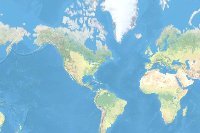

In [13]:
data_item = gis.content.get(demographic_data_id)
data_item

The function ```download``` is used to acquire a zipped version of the shapfile.

In [14]:
zip_path = data_item.download(save_path=path, file_name=data_item.name)

Again, as with the county data, the content is extracted from the Zipfile.

In [15]:
with ZipFile(zip_path) as zip_ref: # open the Zipfile
    filenames = zip_ref.namelist() # get a list of filenames
    for fn in filenames: # find the shapefile
        if fn[-4:] == '.shp':
            print('The shapefile "{}"" will later be renamed to "{}""'.format(fn, rkfn))
            rndct[fn[:-4]] = rkfn # save it to rename dictionary
    zip_ref.extractall(path=tmppath) # extract all data.

The shapefile "Ruutkaart2018.shp"" will later be renamed to "ruutkaart""


## Import Data to GDB

Glob library is helpfull to get the contents of a folder. 

In [16]:
import glob 

In [17]:
os.chdir(tmppath)
shpFiles = glob.glob('*.shp') # use a wildcard to find the Shapefiles in the temporary folder.
print(shpFiles)

['maakond_20200401.shp', 'Ruutkaart2018.shp']


First a fileGDB is necessary to store the data and new feature classes. This can be created with the ```arcpy``` module.

In [18]:
import arcpy

In [19]:
gdbName = r'covid.gdb' # Name of the File Geodatabase
gdbPath = os.path.join(path,gdbName) # Combined path of the Geodatabase
arcpy.env.overwriteOutput = True # allow arcpy to overwrite existing data

In [20]:
result = arcpy.CreateFileGDB_management(path, gdbName)

The list of shapefiles can be passed on to the ```arcpy``` function ```FeatureClassToGeodatabase_conversion``` to copy the data into the created File Geodatabase.

In [21]:
arcpy.env.workspace = path #for now set the workspace to the gisdata directory
result = arcpy.FeatureClassToGeodatabase_conversion(shpFiles, gdbPath)

The content of the Geodatabase can be shown with a range of ```List...``` functions, which are summarized in the [ArcPy documentation](https://pro.arcgis.com/en/pro-app/arcpy/get-started/listing-data.htm). Here, the [ListFeatureClasses](https://pro.arcgis.com/en/pro-app/arcpy/functions/listfeatureclasses.htm) is utilized.

In [22]:
arcpy.env.workspace = gdbPath # now set the workspace to the Geodatabase
fcs = arcpy.ListFeatureClasses()
fcs

['maakond_20200401_shp', 'Ruutkaart2018_shp']

Since the name extension is still present, the [```Rename_management```](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/rename.htm) function is used. The names are assigned based on the previously defined rename dictionary entries (see [1](#rn_county) and [2](#rn_demog)).

In [23]:
for fc in fcs:
    fc_old = fc[:-4] # skip the extension
    if fc_old in rndct: # check if file is in rename-dictionary
        fc_new = rndct[fc_old]  # get new desired file-name
        print('Renaming "{}" to "{}"'.format(fc,fc_new))
        arcpy.Rename_management(fc, fc_new, "FeatureClass")

Renaming "maakond_20200401_shp" to "maakond"
Renaming "Ruutkaart2018_shp" to "ruutkaart"


## Summarize Statistics

In the next step the County polygons are used to summarize the age groups in the demographic dataset.

In [24]:
mkrkfn = 'maakond_ruutkaart' # name of the summarized dataset to be created

The [```SummarizeWithin```](https://pro.arcgis.com/en/pro-app/tool-reference/analysis/summarize-within.htm#GUID-D87042A5-36E6-4CC4-9F3C-7C1BBF5F05E8) tool takes an optional parameter ```sum_fields```. To create it, it is necessary to know which fields shall be used for the Summary. Here the [```ListFields```](https://pro.arcgis.com/en/pro-app/arcpy/functions/listfields.htm) will give an overview of the fields in the demographic dataset.

In [25]:
fieldnames = []
for f in arcpy.ListFields(rkfn): 
    fieldnames.append(f.name)
print(fieldnames)

['OBJECTID', 'Shape', 'GRD_INSPIR', 'TOTAL', 'M_TOTAL', 'F_TOTAL', 'TOT_LT5', 'M_LT5', 'F_LT5', 'TOT_5_9', 'M_5_9', 'F_5_9', 'TOT_10_14', 'M_10_14', 'F_10_14', 'TOT_15_19', 'M_15_19', 'F_15_19', 'TOT_20_24', 'M_20_24', 'F_20_24', 'TOT_25_29', 'M_25_29', 'F_25_29', 'TOT_30_34', 'M_30_34', 'F_30_34', 'TOT_35_39', 'M_35_39', 'F_35_39', 'TOT_40_44', 'M_40_44', 'F_40_44', 'TOT_45_49', 'M_45_49', 'F_45_49', 'TOT_50_54', 'M_50_54', 'F_50_54', 'TOT_55_59', 'M_55_59', 'F_55_59', 'TOT_60_64', 'M_60_64', 'F_60_64', 'TOT_65_69', 'M_65_69', 'F_65_69', 'TOT_70_74', 'M_70_74', 'F_70_74', 'TOT_75_79', 'M_75_79', 'F_75_79', 'TOT_80_84', 'M_80_84', 'F_80_84', 'TOT_GE85', 'M_GE85', 'F_GE85', 'Shape_Length', 'Shape_Area']


Only the fields with population data for the different age groups, are of interest. In this case the WildCard option of the ```ListFields``` function is not helpful. Instead it is possible to check for each fieldname if it matches a certain pattern. In this case the prefixes 
```python
'F_', 'M_', 'TOT'
``` 
can be used.

In [26]:
prefixes = ('F_', 'M_', 'TOT')
sum_fields = [] # here the parameter is defined that is later passed to the SummarizeWithin function
for f in arcpy.ListFields(rkfn):
    if f.name.startswith(prefixes): # check if the fieldname starts with one of the predefind prefixes
        sum_fields.append([f.name ,'SUM']) # append the field name and desired statistics type is defined
print(sum_fields)

[['TOTAL', 'SUM'], ['M_TOTAL', 'SUM'], ['F_TOTAL', 'SUM'], ['TOT_LT5', 'SUM'], ['M_LT5', 'SUM'], ['F_LT5', 'SUM'], ['TOT_5_9', 'SUM'], ['M_5_9', 'SUM'], ['F_5_9', 'SUM'], ['TOT_10_14', 'SUM'], ['M_10_14', 'SUM'], ['F_10_14', 'SUM'], ['TOT_15_19', 'SUM'], ['M_15_19', 'SUM'], ['F_15_19', 'SUM'], ['TOT_20_24', 'SUM'], ['M_20_24', 'SUM'], ['F_20_24', 'SUM'], ['TOT_25_29', 'SUM'], ['M_25_29', 'SUM'], ['F_25_29', 'SUM'], ['TOT_30_34', 'SUM'], ['M_30_34', 'SUM'], ['F_30_34', 'SUM'], ['TOT_35_39', 'SUM'], ['M_35_39', 'SUM'], ['F_35_39', 'SUM'], ['TOT_40_44', 'SUM'], ['M_40_44', 'SUM'], ['F_40_44', 'SUM'], ['TOT_45_49', 'SUM'], ['M_45_49', 'SUM'], ['F_45_49', 'SUM'], ['TOT_50_54', 'SUM'], ['M_50_54', 'SUM'], ['F_50_54', 'SUM'], ['TOT_55_59', 'SUM'], ['M_55_59', 'SUM'], ['F_55_59', 'SUM'], ['TOT_60_64', 'SUM'], ['M_60_64', 'SUM'], ['F_60_64', 'SUM'], ['TOT_65_69', 'SUM'], ['M_65_69', 'SUM'], ['F_65_69', 'SUM'], ['TOT_70_74', 'SUM'], ['M_70_74', 'SUM'], ['F_70_74', 'SUM'], ['TOT_75_79', 'SUM'], [

The fields can then be passed on, and the ```SummarizeWithin``` tool excecuted. (The tool is quite verbose, when excecuted in a Jupyter Notebook, but the results are fine.)

In [ ]:
arcpy.analysis.SummarizeWithin(mkfn, rkfn, mkrkfn, '', sum_fields)

The newly calculated Fields have the prefix ```SUM_```, which can be removed with the [```AlterField_management```](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/alter-field-properties.htm) function

In [28]:
srString = "SUM_" # search and replace string
fields= [fc.name for fc in arcpy.ListFields(mkrkfn, "{}*".format(srString))] # list all fields with WildCard search
for field in fields:
    new_fn = field.replace(srString, '') # replace the s&r string
    arcpy.AlterField_management(mkrkfn, field, new_fn, new_fn) # rename the field

The ```SummarizeWithin``` function calculates the SUM for each agegroup and county based on underlying grid (ruutkaart). When a grid cell falls into 2 polygons the sum is calculated based on the respective proportion, which results in floating point results. In the next step, the values are rounded based on given desired precision. 

In [29]:
prc = 0 # precision for rounding
for field in arcpy.ListFields(mkrkfn):
    if field.name.startswith(prefixes):
        arcpy.CalculateField_management(mkrkfn, field.name, 'round(!{}!,{})'.format(field.name,prc), "PYTHON3")

The demographic dataset consists of age groups in 5 year intervals, from 0 - 85 years. Population older than 85 is combined in the ```*_GE85``` group. In this step the fields for the years 60 and more years are summed in the field ```*_GE60```, as they represent a high risk group. (This is just one of many risk groups, information can be found in the official resources: [Terviseamet](https://www.terviseamet.ee/en/coronavirus-risk-group), [CDC](https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-at-higher-risk.html). **This is just an example data workflow!**)

In [30]:
prefixes = ('F_', 'M_', 'TOT_') 
for prefix in prefixes: # do this for the two given sex groups, as well as the total
    field = "{pref}GE60".format(pref=prefix) # new fieldname
    arcpy.AddField_management(mkrkfn, field, "DOUBLE") # add new field
    # calculate new field value
    arcpy.CalculateField_management(mkrkfn, field, '!{pref}60_64! + !{pref}65_69! + !{pref}70_74! + !{pref}75_79! + !{pref}80_84! + !{pref}GE85!'.format(pref=prefix), "PYTHON3")

## Feature class to dataframe and unstack

In the following the summarized dataset is restructured, and converted to a Pandas DataFrame. Later the data is exported to CSV and imported to File Geodatabase.

In [31]:
os.chdir(start_dir) # go back to start directory to load aglearn
from aglearn import remap as rm # load aglearn module, which contains additional functions and variables
from pprint import pprint # import module for pretty printing of dictionaries

In [32]:
fieldnames= [fc.name for fc in arcpy.ListFields(mkrkfn)] 

In [34]:
pdct = {}
prefixes = ('F_', 'M_') # exclude TOT from this search, focus only F/M
with arcpy.da.SearchCursor(mkrkfn, fieldnames) as sCursor: # create search cursor object on summarized dataset
    for row in sCursor: # loop through rows
        mkood = row[fieldnames.index('MKOOD')] # get the MKOOD identifier, identifying the county (Maakond)
        for fieldname in fieldnames: # loop through all fieldnames  and only perform action, when..
            if fieldname.startswith(prefixes): # fieldnames starts with desired prefix
                if fieldname[2:] in rm.VANUSERRK_STR: # and the agegroup is defined in the rename dictionary
                    # create dictionary with tuple as keys (later used as multiindex)
                    pdct[(mkood,fieldname[:1],rm.VANUSERRK_STR[fieldname[2:]])] = row[fieldnames.index(fieldname)]
pprint(pdct) 

{('0037', 'F', '00-04'): 16505.0,
 ('0037', 'F', '05-09'): 17601.0,
 ('0037', 'F', '10-14'): 15122.0,
 ('0037', 'F', '15-19'): 12085.0,
 ('0037', 'F', '20-24'): 14950.0,
 ('0037', 'F', '25-29'): 22363.0,
 ('0037', 'F', '30-34'): 24783.0,
 ('0037', 'F', '35-39'): 23307.0,
 ('0037', 'F', '40-44'): 21606.0,
 ('0037', 'F', '45-49'): 19481.0,
 ('0037', 'F', '50-54'): 17366.0,
 ('0037', 'F', '55-59'): 19582.0,
 ('0037', 'F', '60-64'): 19578.0,
 ('0037', 'F', '65-69'): 18608.0,
 ('0037', 'F', '70-74'): 13482.0,
 ('0037', 'F', '75-79'): 14516.0,
 ('0037', 'F', '80-84'): 10502.0,
 ('0037', 'F', '85+'): 9581.0,
 ('0037', 'M', '00-04'): 17598.0,
 ('0037', 'M', '05-09'): 18306.0,
 ('0037', 'M', '10-14'): 16084.0,
 ('0037', 'M', '15-19'): 12545.0,
 ('0037', 'M', '20-24'): 14273.0,
 ('0037', 'M', '25-29'): 21422.0,
 ('0037', 'M', '30-34'): 24095.0,
 ('0037', 'M', '35-39'): 22725.0,
 ('0037', 'M', '40-44'): 21566.0,
 ('0037', 'M', '45-49'): 18786.0,
 ('0037', 'M', '50-54'): 15850.0,
 ('0037', 'M', '5

In [35]:
import pandas as pd

In [36]:
dfx = pd.DataFrame.from_dict(pdct, orient="index")
dfx.index = pd.MultiIndex.from_tuples(dfx.index, names=('MKOOD', 'GENDER', 'AGEGROUP'))
dfx = dfx.rename(columns={0:'COUNT'}).reset_index()
dfx['County'] = dfx['MKOOD'].map(rm.MKOOD_MNIMI)
dfx.to_csv(r'demog_data.csv', index=False)
dfx

,MKOOD,GENDER,AGEGROUP,COUNT,County
0,0074,M,00-04,733.0,Saare maakond
1,0074,F,00-04,672.0,Saare maakond
2,0074,M,05-09,827.0,Saare maakond
3,0074,F,05-09,769.0,Saare maakond
4,0074,M,10-14,770.0,Saare maakond
...,...,...,...,...,...
535,0064,F,75-79,675.0,Põlva maakond
536,0064,M,80-84,204.0,Põlva maakond
537,0064,F,80-84,557.0,Põlva maakond
538,0064,M,85+,157.0,Põlva maakond


(There are several ways to perform this task. Before the above loop, it is possible to [create a empty table](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/create-table.htm) with ```arcpy```, [add necessary fields](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/add-field.htm) and fill the table subsequentially in the loop.)

In [37]:
agcofn = 'agegroup_county'
result = arcpy.conversion.TableToTable(r'demog_data.csv', gdbPath, agcofn)

Unfortunately, the field ```MKOOD``` has been imported as integer. To fix this, a new field is added, calculated, and renamed. (Alternatively, this could have been prevented by using [```FieldMappings```](https://pro.arcgis.com/en/pro-app/arcpy/classes/fieldmappings.htm), during data import.)

In [38]:
arcpy.AddField_management(agcofn, 'MKOOD_STR', 'TEXT', field_length=5)
arcpy.CalculateField_management(agcofn, 'MKOOD_STR', "'{:04d}'.format(int(!MKOOD!))", "PYTHON3")
arcpy.DeleteField_management(agcofn, 'MKOOD')
result = arcpy.AlterField_management(agcofn, 'MKOOD_STR', 'MKOOD', 'MKOOD', 'TEXT')